<a href="https://colab.research.google.com/github/limedosa/New-York-Botanical-Gardens-Image-Classification/blob/main/NYBG_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input direct
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split

from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout, Normalization,CenterCrop
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet50, ResNet101V2
from tensorflow.keras.applications.resnet50 import preprocess_input

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm  as cm
import seaborn as sns
import cv2

2024-03-31 14:53:37.270102: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-31 14:53:37.270213: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-31 14:53:37.437128: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
fullTrainDF = pd.read_csv('/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-train.csv')
fullTestDF = pd.read_csv('/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-test.csv')
fullValidationDF = pd.read_csv('/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-validation.csv')
sampleSubmissionDF = pd.read_csv('/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-sample_submission.csv')

testImageDirectory = '/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-test/BTTAIxNYBG-test/'
trainImageDirectory = '/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-train/BTTAIxNYBG-train/'
validationImageDirectory = '/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-validation/BTTAIxNYBG-validation/'

In [ ]:
fullTestDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30690 entries, 0 to 30689
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   uniqueID   30690 non-null  int64 
 1   imageFile  30690 non-null  object
dtypes: int64(1), object(1)
memory usage: 479.7+ KB


In [ ]:
# trainDF, df = train_test_split(fullTrainDF, test_size=0, random_state=42)
# validationDF, validationdf = train_test_split(fullValidationDF, test_size=0, random_state=42)
# testDF, testDF = train_test_split(fullValidationDF, test_size=.90, random_state=42)
trainDF = fullTrainDF
validationDF = fullValidationDF

In [ ]:
trainDF.head()

,uniqueID,classLabel,classID,source,imageFile
0,2,occluded-specimens,8,L,a1a8b48e8cb142b3.jpg
1,3,microscope-slides,6,L,79599db2ac9092b6.jpg
2,4,illustrations-color,2,BHL,c449696f2f0d0d92.jpg
3,5,illustrations-color,2,P,80a8f4a393b4e08c.jpg
4,6,animal-specimens,0,AK,041a1c6e73313638.jpg


In [ ]:
trainDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81946 entries, 0 to 81945
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   uniqueID    81946 non-null  int64 
 1   classLabel  81946 non-null  object
 2   classID     81946 non-null  int64 
 3   source      81946 non-null  object
 4   imageFile   81946 non-null  object
dtypes: int64(2), object(3)
memory usage: 3.1+ MB


In [ ]:
sampleSubmissionDF.head(10)

,uniqueID,classID
0,1,5
1,9,7
2,10,6
3,14,1
4,16,3
5,24,5
6,25,1
7,26,2
8,28,8
9,34,6


In [ ]:
for column in trainDF.columns[1:-1]:
    print(column)
    print(trainDF[column].value_counts())

classLabel
classLabel
live-plants                       8200
illustrations-color               8196
illustrations-gray                8196
biocultural-specimens             8195
micrographs-transmission-light    8195
occluded-specimens                8194
animal-specimens                  8194
mixed-pressed-specimens           8193
microscope-slides                 8192
ordinary-pressed-specimens        8191
Name: count, dtype: int64
classID
classID
4    8200
2    8196
3    8196
1    8195
5    8195
8    8194
0    8194
7    8193
6    8192
9    8191
Name: count, dtype: int64
source
source
BHL      12691
L         8812
Tw        5274
K         5261
NY        5183
P         4755
BR        3789
Met       3438
F         3365
US        3064
E         2977
AK        2307
MICH      2163
CAS       1825
MO        1725
GH        1573
C         1564
YU        1380
O         1294
RSA       1037
KY         655
UA         655
FMNH       654
TU         647
MZH        612
MPU        603
NMR        600
M

In [ ]:
fileNames = trainDF['imageFile'].values
fileNamesClasses = trainDF['classLabel'].values
print("there are: ", len(fileNames), ' img in training dataset')

there are:  81946  img in training dataset


In [ ]:
fileNamesVal = validationDF['imageFile'].values
fileNamesClassesVal = validationDF['classLabel'].values
print("there are: ", len(fileNamesVal), ' img in training dataset')

there are:  10244  img in training dataset


In [ ]:
PATH = trainImageDirectory
images= []
imagesClass=[]
for i in range(0,10):
    file = fileNames[i]
    imagesClass.append(fileNamesClasses[i])
    filepath = os.path.join(PATH, file)
    image = Image.open(filepath)
    images.append(np.asarray(image))
images=np.array(images, dtype='object')

len(images)

10

In [ ]:
fig = plt.figure(figsize=(10, 7))
rows = 2
columns = 2
# plt.show()

# fig.imshow


print(images[1].shape)
print('minimum val in array:',max(arr.max() for arr in images),'minimum val in array:',(min(arr.min() for arr in images)))

(2234, 768, 3)
minimum val in array: 255 minimum val in array: 0


<Figure size 1000x700 with 0 Axes>

make Keras data generators

data augmentation

# Keras Data generators

In [ ]:
mean= np.array([.485, .456, .406])
std = np.array([.229, .224, .225])

def randCropAugmentation(img):
    img = image_preprocessing.preprocess_for_train(img)
    img = tf.image.random_brightness(img, .2)
    img = tf.image.random_contract(img, .5, 2)
    img = tf.image.random_saturation(img, .75, 1.25)
    img = tf.image.random_hue(img, .1)
    return img


In [ ]:
def randomCrop(img):
    # Determine the crop size
    crop_height = 224  # Set your desired crop height
    crop_width = 224   # Set your desired crop width

    # Get the dimensions of the input image
    img_height, img_width, _ = img.shape

    # Calculate the maximum allowable starting position for the crop
    max_x = img_width - crop_width
    max_y = img_height - crop_height

    # Generate random starting positions for the crop
    start_x = np.random.randint(0, max_x + 1)
    start_y = np.random.randint(0, max_y + 1)

    # Crop the image
    cropped_img = img[start_y:start_y + crop_height, start_x:start_x + crop_width, :]

    return cropped_img


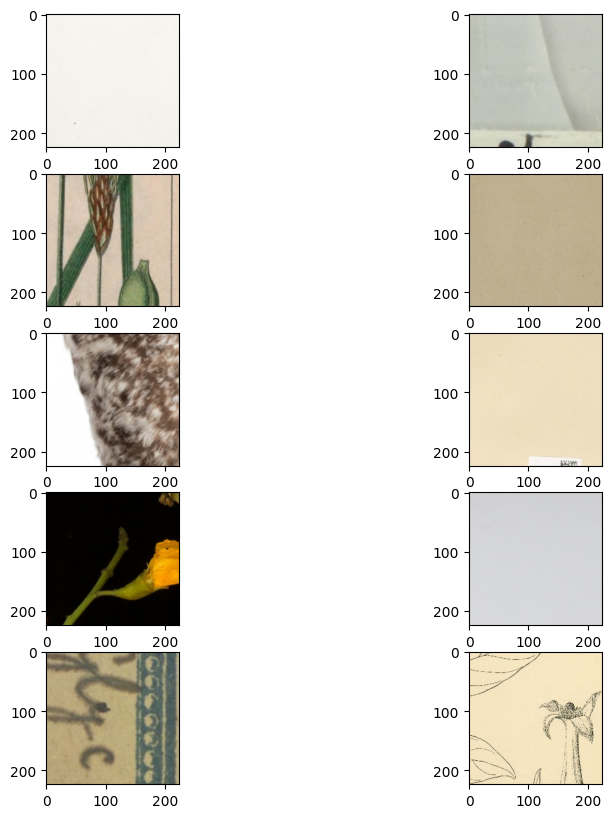

In [ ]:
croppedImages = [randomCrop(img) for img in images]
croppedImages
import matplotlib.pyplot as plt

rows = 5
columns = 2

fig = plt.figure(figsize=(10, 10))

for i in range(rows * columns):
    ax = fig.add_subplot(rows, columns, i+1)

    ax.imshow(croppedImages[i])

#     ax.axis('off')

plt.show()


In [ ]:
def load_and_preprocess_image(image_path_or_array, desired_width=224, desired_height=224):
    if isinstance(image_path_or_array, str):
        # If it's a file path, read the image
        img = cv2.imread(image_path_or_array)
    else:
        # If it's a numpy array, use it directly
        img = image_path_or_array

    # Resize the image to the desired dimensions
    img = cv2.resize(img, (desired_width, desired_height))

    # Normalize the pixel values
    img = img / 255.0

    return img

In [ ]:
train_datagen = ImageDataGenerator(
#     rescale=1./255,
    rotation_range=40,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=load_and_preprocess_image
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=load_and_preprocess_image,
#     rescale=1./255
)
test_datagen = ImageDataGenerator(
    preprocessing_function=load_and_preprocess_image,
#     rescale=1./255
)

In [ ]:
test_datagen

In [ ]:
def df_to_dataset(df, imgDirectory, datagen, batch_size=32):
    dataset = datagen.flow_from_dataframe(
        dataframe=df,
        directory=imgDirectory,
        x_col='imageFile',
        y_col='classLabel',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical'  # Because it's multiclass
    )
    return dataset

train_dataset = df_to_dataset(trainDF, trainImageDirectory, train_datagen, 32)
validation_dataset = df_to_dataset(validationDF, validationImageDirectory, validation_datagen, 32)


Found 81946 validated image filenames belonging to 10 classes.
Found 10244 validated image filenames belonging to 10 classes.


In [ ]:

# testing_dataset = df_to_dataset(testDF, testImageDirectory, test_datagen, 32)
# len(testing_dataset)
fullTestDF
trainDF

,uniqueID,classLabel,classID,source,imageFile
0,2,occluded-specimens,8,L,a1a8b48e8cb142b3.jpg
1,3,microscope-slides,6,L,79599db2ac9092b6.jpg
2,4,illustrations-color,2,BHL,c449696f2f0d0d92.jpg
3,5,illustrations-color,2,P,80a8f4a393b4e08c.jpg
4,6,animal-specimens,0,AK,041a1c6e73313638.jpg
...,...,...,...,...,...
81941,122874,micrographs-transmission-light,5,Tw,2424355d5438181c.jpg
81942,122875,illustrations-color,2,BHL,b28acccccecad04c.jpg
81943,122876,microscope-slides,6,L,78f6868694a6669c.jpg
81944,122877,live-plants,4,E,5c6162948949510a.jpg


In [ ]:
def plotImages(imgArr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(imgArr, axes):
        ax.imshow(img)  # Accessing the first batch and ith image
#         ax.axis('off')
    plt.tight_layout()
    plt.show()


In [ ]:
# import cv2
# desired_width = 224
# desired_height = 224



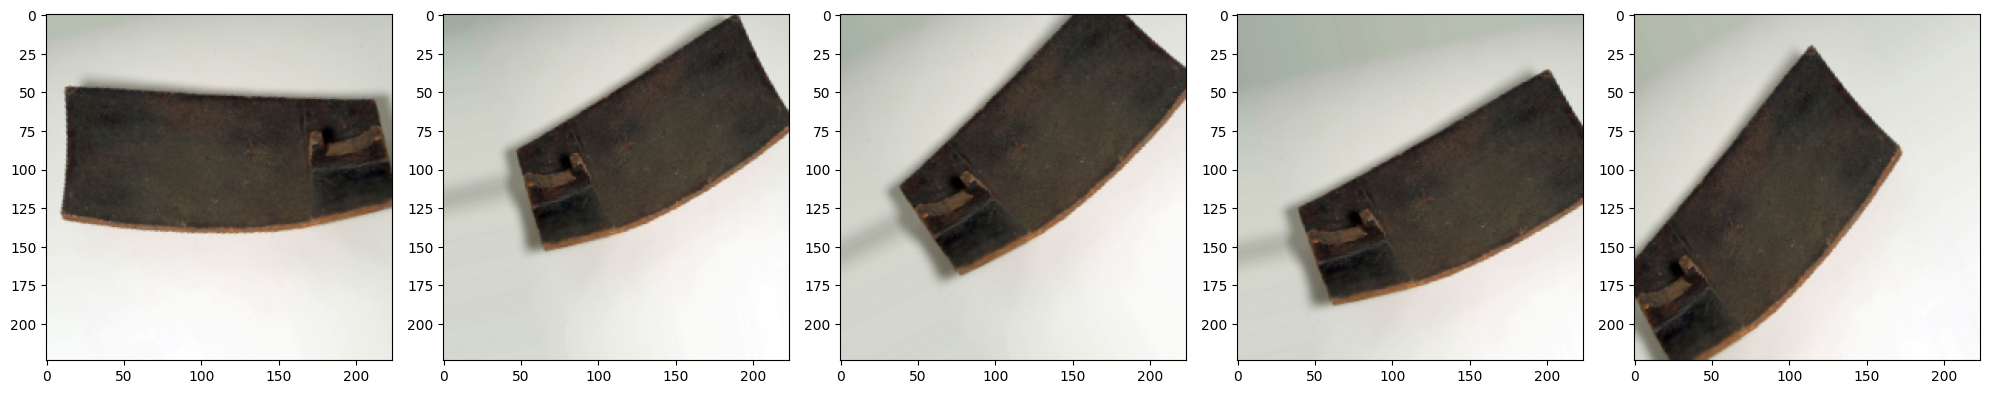

In [ ]:
trainAugmentedImg = [train_dataset[20][0][0] for i in range(5)]
plotImages(trainAugmentedImg)

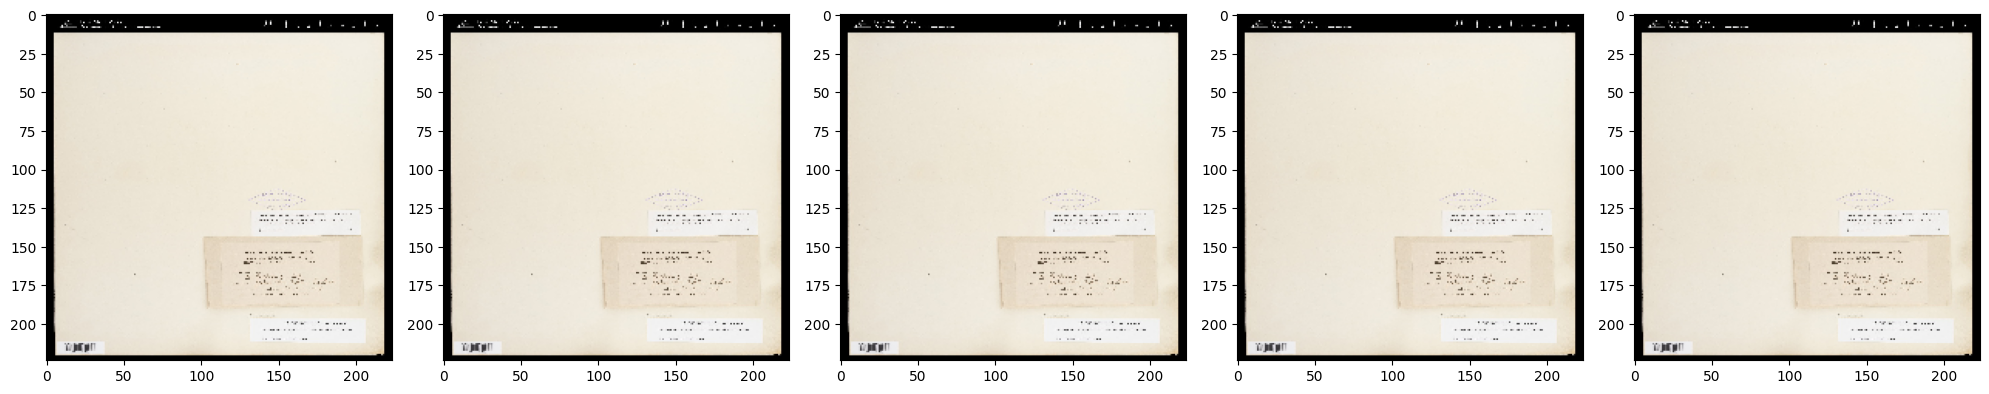

In [ ]:
def plotImages(imgArr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(imgArr, axes):
        ax.imshow(img)  # Accessing the first batch and ith image
#         ax.axis('off')
    plt.tight_layout()
    plt.show()

validationAugmentedImg = [validation_dataset[1][0][0] for i in range(5)] #just picked random example
plotImages(validationAugmentedImg)

In [ ]:
# for images, labels in validation_dataset:
#     for i in range(1):
#         plt.imshow(images[i])
#         plt.show()

In [ ]:
labels= (train_dataset.class_indices)
labels=dict((v,k) for k,v in labels.items())
labels

{0: 'animal-specimens',
 1: 'biocultural-specimens',
 2: 'illustrations-color',
 3: 'illustrations-gray',
 4: 'live-plants',
 5: 'micrographs-transmission-light',
 6: 'microscope-slides',
 7: 'mixed-pressed-specimens',
 8: 'occluded-specimens',
 9: 'ordinary-pressed-specimens'}

# Models


In [ ]:
print("num classes: ", len(labels))
numClasses = len(labels)

num classes:  10


In [ ]:
def modelToDF(modelHistory):
    """turn model output into df"""
    modelHistoryDict = modelHistory.history

    #create df from history dict
    df = pd.DataFrame(modelHistoryDict)
    #return df
    return df

# ResNet50 Model

In [ ]:
numEpochs= 8
earlyStopPatience= 4

In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Flatten
# from tensorflow.keras.applications import ResNet50
# import keras


# #initialize Sequential model
# model50 = Sequential()

# #load ResNet50 model w/ imagenet weights, excluding top classification layer
# ResNet50Model = ResNet50(include_top=False,
#                           input_shape=(224, 224, 3),
#                           pooling='avg',
#                           weights='imagenet'
#                          )

# for layer in imported_model.layers:
#     layer.trainable = True

# model50.add(ResNet50Model)

# model50.add(Flatten())

# model50.add(Dense(512, activation='sigmoid'))

# model50.add(Dense(numClasses, activation='softmax'))

# adam = keras.optimizers.Adam(learning_rate=1e-3)
# model50.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
# model50Output=model50.fit(train_dataset, validation_data= validation_dataset, epochs=numEpochs, batch_size=32)


In [ ]:
# model50DF= modelToDF(model50Output)
# model50DF.head()

**Model 50 Summary:**

preforms worse than other models.

In [ ]:
# # IN PROGRESS
# VGG16Base= keras.applications.VGG16(
#     include_top=False,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=(224, 224, 3),
#     pooling=None,
#     classes=10,
#     classifier_activation="softmax",
# )
# VGG16Base.trainable=True
# # for layers in model_base.layers[:-30]:
# #     layers.trainable=False
# inputs=tf.keras.Input(shape=(224,224,3))
# x=VGG16Base(inputs)
# # x=GlobalAveragePooling2D()(x)
# x=Dropout(.5)(x)
# outputs=Dense(numClasses, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(1e-3))(x)
# modelVGG16Base=tf.keras.Model(inputs=inputs, outputs=outputs)
# adam = keras.optimizers.Adam(learning_rate=1e-4)
# modelVGG16Base.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
# modelVGG16History=modelVGG16Base.fit(train_dataset, validation_data= validation_dataset, epochs=numEpochs)


# Train Model

In [ ]:
# stepSizeTrain = train_dataset.n//train_dataset.batch_size
# stepSizeValid = validation_dataset.n//validation_dataset.batch_size
# print(stepSizeTrain)
# print(stepSizeValid)

In [ ]:
#training funct
def trainModel(model, epochs, optimizer):
    batch_size=32
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])
    return model.fit(train_dataset, validation_data= validation_dataset, epochs=epochs, batch_size=batch_size)

In [ ]:
# model_history = trainModel(model=model, epochs=10, optimizer="Adam")

Stopping & Model Checkpoint Callbacks

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#early stopping and model checkpoint callbacks
cb_early_stopper = EarlyStopping(monitor='val_loss', patience=earlyStopPatience)
cb_checkpointer = ModelCheckpoint(filepath='./working/best_ResNet101V2.keras',
                                  monitor='val_loss',
                                  save_best_only=True,
                                  mode='auto'
                                 )


In [ ]:
# model_history = model.fit(
#     train_dataset,
#     validation_data=validation_dataset,
#     epochs=numEpochs,
#     callbacks=[cb_checkpointer, cb_early_stopper])

train with less epochs

# Second Model - ResNet101V2

In [ ]:
modelRN101Base= ResNet101V2(
    input_shape=(224, 224, 3),
    include_top=False,)
modelRN101Base.trainable=True
for layers in modelRN101Base.layers[:-20]: #change freezing
    layers.trainable=False
inputs=tf.keras.Input(shape=(224,224,3))
x=modelRN101Base(inputs)
x=GlobalAveragePooling2D()(x)
x=Dropout(.2)(x) #try convolutional insteadd of dropout
#add some dense layers
outputs=Dense(numClasses, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(1e-3))(x)
modelRN101=tf.keras.Model(inputs=inputs, outputs=outputs)
adam = keras.optimizers.Adam(learning_rate=1e-4)
modelRN101.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
modelRN101.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet101v2 (Functional)        │ (None, 7, 7, 2048)     │    42,626,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,647,050 (162.69 MB)

 Trainable params: 7,900,170 (30.14 MB)

 Non-trainable params: 34,746,880 (132.55 MB)

In [ ]:
modelRN101Output = modelRN101.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=numEpochs,
    callbacks=[cb_checkpointer, cb_early_stopper])

Epoch 1/8


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1711897192.352450      92 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1711897192.426724      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1305/2561 ━━━━━━━━━━━━━━━━━━━━ 15:40 749ms/step - accuracy: 0.8319 - loss: 0.5338

W0000 00:00:1711898169.049786      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2561/2561 ━━━━━━━━━━━━━━━━━━━━ 0s 761ms/step - accuracy: 0.8713 - loss: 0.4106

W0000 00:00:1711899148.902032      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711899324.561757      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2561/2561 ━━━━━━━━━━━━━━━━━━━━ 2173s 833ms/step - accuracy: 0.8713 - loss: 0.4105 - val_accuracy: 0.9535 - val_loss: 0.1428
Epoch 2/8
2561/2561 ━━━━━━━━━━━━━━━━━━━━ 1649s 642ms/step - accuracy: 0.9514 - loss: 0.1531 - val_accuracy: 0.9585 - val_loss: 0.1297
Epoch 3/8
2561/2561 ━━━━━━━━━━━━━━━━━━━━ 2139s 833ms/step - accuracy: 0.9611 - loss: 0.1250 - val_accuracy: 0.9629 - val_loss: 0.1179
Epoch 4/8
2561/2561 ━━━━━━━━━━━━━━━━━━━━ 1665s 632ms/step - accuracy: 0.9645 - loss: 0.1103 - val_accuracy: 0.9665 - val_loss: 0.1114
Epoch 5/8
2561/2561 ━━━━━━━━━━━━━━━━━━━━ 1777s 692ms/step - accuracy: 0.9698 - loss: 0.0967 - val_accuracy: 0.9655 - val_loss: 0.1088
Epoch 6/8
2561/2561 ━━━━━━━━━━━━━━━━━━━━ 1846s 719ms/step - accuracy: 0.9714 - loss: 0.0901 - val_accuracy: 0.9684 - val_loss: 0.1046
Epoch 7/8
2561/2561 ━━━━━━━━━━━━━━━━━━━━ 1837s 716ms/step - accuracy: 0.9737 - loss: 0.0844 - val_accuracy: 0.9642 - val_loss: 0.1151
Epoch 8/8
2561/2561 ━━━━━━━━━━━━━━━━━━━━ 1784s 695ms/step - accuracy: 0.

In [ ]:
#loading and saving weights
modelRN101.load_weights('./working/best_ResNet101V2.keras')

In [ ]:
modelRN101DF = modelToDF(modelRN101Output)
modelRN101DF.head()

,accuracy,loss,val_accuracy,val_loss
0,0.920716,0.254996,0.953534,0.142772
1,0.952615,0.149505,0.958512,0.129722
2,0.960620,0.123621,0.962905,0.117895
3,0.965282,0.109461,0.966517,0.111428
4,0.969407,0.097811,0.965541,0.108804


In [ ]:
sampleSubmissionDF.head(10)

,uniqueID,classID
0,1,5
1,9,7
2,10,6
3,14,1
4,16,3
5,24,5
6,25,1
7,26,2
8,28,8
9,34,6


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
image_size = (224, 224)

test_datagen = ImageDataGenerator(
    preprocessing_function=load_and_preprocess_image,  # Your preprocessing function
)


# Create a test generator using flow_from_dataframe
test_generator = test_datagen.flow_from_dataframe(
    dataframe=fullTestDF,
    directory=testImageDirectory,
    x_col='imageFile',  # Column containing image filenames
    y_col=None,  # Test set does not have labels
    target_size=image_size,
    batch_size=batch_size,
    class_mode=None,  # Test set does not have labels
    shuffle=False  # Do not shuffle the test data
)


Found 30690 validated image filenames.


In [ ]:
def df_to_test_dataset(df, imgDirectory, datagen, batch_size=32):
    dataset = datagen.flow_from_dataframe(
        dataframe=df,
        directory=imgDirectory,
        x_col='imageFile',
        y_col=None,  # Test set does not have labels
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode=None,  # Test set does not have labels
        shuffle=False  # Do not shuffle the test data
    )
    return dataset

test_dataset = df_to_test_dataset(fullTestDF, testImageDirectory, test_datagen, 32)


Found 30690 validated image filenames.


In [ ]:
fullTestDF

,uniqueID,imageFile
0,1,facd4dcd8e869617.jpg
1,9,78c96bb2b2b62579.jpg
2,10,d292d2c4e0e6ad9d.jpg
3,14,3633494929870713.jpg
4,16,dc94b496c8e2d6c4.jpg
...,...,...
30685,122864,9ab2ba9a949abab2.jpg
30686,122868,ccccede8cccccc4f.jpg
30687,122871,31ccec6c99ccec68.jpg
30688,122878,de1e0f1f0e0e9e9e.jpg


In [ ]:
# test_generator = test_datagen.flow_from_dataframe(
#     dataframe=fullTestDF,
#     directory=testImageDirectory,
#     x_col='imageFile',
#     y_col=None,  # Test set does not have labels
#     target_size=(desired_width, desired_height),
#     batch_size=32,
#     class_mode=None,  # Test set does not have labels
#     shuffle=False  # Do not shuffle the test data
# )

# # Predict class labels for the testing images
# predictions = modelRN101.predict(test_generator)

# # Convert the predicted probabilities to class labels
# predicted_class_ids = predictions.argmax(axis=1)

# # Create a submission DataFrame
# submission_df = pd.DataFrame({'uniqueID': testDF['uniqueID'], 'classID': predicted_class_ids})

# # Save the submission DataFrame to a CSV file
# submission_df.to_csv('/kaggle/working/submission.csv', index=False)

In [ ]:
fullTestDF['uniqueID']

check how each individual class
*

# turning model RN 101 into csv

In [ ]:
predictions = modelRN101.predict(test_dataset) #using model to train

predictedClassIDs = predictions.argmax(axis=1)

uniqueIDs = fullTestDF['uniqueID']

submissionDF = pd.DataFrame({'uniqueID': uniqueIDs, 'classID': predictedClassIDs})

submissionDF.to_csv('/kaggle/working/submission101.csv', index=False)

print(submissionDF.head(30))

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/960 ━━━━━━━━━━━━━━━━━━━━ 1:46 111ms/step

W0000 00:00:1711912633.499954      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


960/960 ━━━━━━━━━━━━━━━━━━━━ 483s 495ms/step


W0000 00:00:1711913108.213550      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


    uniqueID  classID
0          1        1
1          9        7
2         10        4
3         14        1
4         16        6
5         24        1
6         25        4
7         26        8
8         28        5
9         34        0
10        35        6
11        36        8
12        40        5
13        42        7
14        49        1
15        51        2
16        54        4
17        56        5
18        61        8
19        63        6
20        64        0
21        67        2
22        79        1
23        80        5
24        82        7
25        87        7
26        98        2
27       107        2
28       110        6
29       112        0


In [ ]:
submissionDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30690 entries, 0 to 30689
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   uniqueID  30690 non-null  int64
 1   classID   30690 non-null  int64
dtypes: int64(2)
memory usage: 479.7 KB


In [ ]:
# test_loss, test_accuracy = modelRN101.evaluate(test_dataset)
# print("Test Loss:", test_loss)
# print("Test Accuracy:", test_accuracy)


In [ ]:
import matplotlib.pyplot as plt
def plotLoss(model):
    """
    plots the model's training and validation loss
    """
    #get training & validation loss from modelHistory
    trainLoss = model.history['loss']
    valLoss = model.history['val_loss']

    # Plot training and validation loss
    plt.plot(trainLoss, label='Training Loss')
    plt.plot(valLoss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.show()


trying 2 again

In [ ]:
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import Dropout

baseModel2= ResNet101V2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
# Define the model architecture
inputs = tf.keras.Input(shape=(224, 224, 3))
x = baseModel2(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)  # Increase dropout rate for stronger regularization
x = Dense(512, activation='relu', kernel_regularizer=l1(0.001))(x)  # Add L1 regularization
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

# Create the model
model_1_2_regularized = Model(inputs, outputs)

# Compile the model
adam = keras.optimizers.Adam(learning_rate=0.0001)
model_1_2_regularized.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# Print model summary
model_1_2_regularized.summary()


In [ ]:
modelRN101Output2 = model_1_2_regularized.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=numEpochs,
    callbacks=[cb_checkpointer, cb_early_stopper])

Epoch 1/10


W0000 00:00:1711513129.595772      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


142/257 ━━━━━━━━━━━━━━━━━━━━ 1:38 857ms/step - accuracy: 0.4760 - loss: 25.8745

W0000 00:00:1711513250.720478      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 727ms/step - accuracy: 0.5820 - loss: 24.6599

W0000 00:00:1711513323.442910      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


257/257 ━━━━━━━━━━━━━━━━━━━━ 304s 789ms/step - accuracy: 0.5827 - loss: 24.6503 - val_accuracy: 0.9023 - val_loss: 17.8873
Epoch 2/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 150s 569ms/step - accuracy: 0.8853 - loss: 16.3405 - val_accuracy: 0.9248 - val_loss: 12.1131
Epoch 3/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 152s 576ms/step - accuracy: 0.9280 - loss: 11.0097 - val_accuracy: 0.9336 - val_loss: 7.9571
Epoch 4/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 152s 577ms/step - accuracy: 0.9387 - loss: 7.0709 - val_accuracy: 0.9160 - val_loss: 4.8924


In [ ]:
modelRN101Output2DF = modelToDF(modelRN101Output2)
modelRN101Output2DF.head()

In [ ]:
# cb_early_stopper = EarlyStopping(monitor='val_loss', patience=earlyStopPatience)
#more epochs
modelRN101Output2_1 = model_1_2_regularized.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=15,
    callbacks=[cb_checkpointer, cb_early_stopper])

Epoch 1/15
257/257 ━━━━━━━━━━━━━━━━━━━━ 153s 578ms/step - accuracy: 0.9661 - loss: 0.4958 - val_accuracy: 0.9453 - val_loss: 0.4941
Epoch 2/15
257/257 ━━━━━━━━━━━━━━━━━━━━ 151s 572ms/step - accuracy: 0.9598 - loss: 0.4698 - val_accuracy: 0.9072 - val_loss: 0.6065
Epoch 3/15
257/257 ━━━━━━━━━━━━━━━━━━━━ 150s 569ms/step - accuracy: 0.9612 - loss: 0.4233 - val_accuracy: 0.9346 - val_loss: 0.4595
Epoch 4/15
257/257 ━━━━━━━━━━━━━━━━━━━━ 149s 563ms/step - accuracy: 0.9676 - loss: 0.4047 - val_accuracy: 0.9219 - val_loss: 0.5776
Epoch 5/15
257/257 ━━━━━━━━━━━━━━━━━━━━ 151s 571ms/step - accuracy: 0.9688 - loss: 0.4082 - val_accuracy: 0.9238 - val_loss: 0.5062
Epoch 6/15
257/257 ━━━━━━━━━━━━━━━━━━━━ 149s 565ms/step - accuracy: 0.9617 - loss: 0.4275 - val_accuracy: 0.9160 - val_loss: 0.5121
Epoch 7/15
257/257 ━━━━━━━━━━━━━━━━━━━━ 153s 579ms/step - accuracy: 0.9691 - loss: 0.3331 - val_accuracy: 0.9014 - val_loss: 0.6571


In [ ]:
earlyStopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., validation loss)
    patience=5,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the model weights from the epoch with the best value of the monitored metric
)

modelRN101Output2_2 = model_1_2_regularized.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=15,
    callbacks=[earlyStopping])

Epoch 1/15
257/257 ━━━━━━━━━━━━━━━━━━━━ 153s 579ms/step - accuracy: 0.9711 - loss: 0.3434 - val_accuracy: 0.8359 - val_loss: 0.7882
Epoch 2/15
257/257 ━━━━━━━━━━━━━━━━━━━━ 153s 579ms/step - accuracy: 0.9738 - loss: 0.2922 - val_accuracy: 0.9316 - val_loss: 0.4994
Epoch 3/15
257/257 ━━━━━━━━━━━━━━━━━━━━ 151s 572ms/step - accuracy: 0.9743 - loss: 0.3266 - val_accuracy: 0.9277 - val_loss: 0.5050
Epoch 4/15
257/257 ━━━━━━━━━━━━━━━━━━━━ 152s 573ms/step - accuracy: 0.9701 - loss: 0.3593 - val_accuracy: 0.9365 - val_loss: 0.4005
Epoch 5/15
257/257 ━━━━━━━━━━━━━━━━━━━━ 153s 579ms/step - accuracy: 0.9740 - loss: 0.2733 - val_accuracy: 0.9219 - val_loss: 0.5334
Epoch 6/15
257/257 ━━━━━━━━━━━━━━━━━━━━ 153s 580ms/step - accuracy: 0.9720 - loss: 0.3708 - val_accuracy: 0.9531 - val_loss: 0.3496
Epoch 7/15
257/257 ━━━━━━━━━━━━━━━━━━━━ 152s 577ms/step - accuracy: 0.9770 - loss: 0.2764 - val_accuracy: 0.9375 - val_loss: 0.4098
Epoch 8/15
257/257 ━━━━━━━━━━━━━━━━━━━━ 152s 576ms/step - accuracy: 0.9768 -

In [ ]:
modelRN101Output2_3 = model_1_2_regularized.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=12,
    callbacks=[earlyStopping])

In [ ]:
earlyStopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., validation loss)
    patience=6,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the model weights from the epoch with the best value of the monitored metric
)

modelRN101Output2_4 = model_1_2_regularized.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=11,
    callbacks=[earlyStopping])

In [ ]:
#og model more epochs
modelRN101Output3 = modelRN101.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=15,
    callbacks=[cb_checkpointer, cb_early_stopper])

Epoch 1/15
257/257 ━━━━━━━━━━━━━━━━━━━━ 161s 611ms/step - accuracy: 0.9665 - loss: 0.1092 - val_accuracy: 0.9424 - val_loss: 0.1841
Epoch 2/15
257/257 ━━━━━━━━━━━━━━━━━━━━ 149s 564ms/step - accuracy: 0.9684 - loss: 0.1270 - val_accuracy: 0.9189 - val_loss: 0.2776
Epoch 3/15
257/257 ━━━━━━━━━━━━━━━━━━━━ 203s 569ms/step - accuracy: 0.9702 - loss: 0.1070 - val_accuracy: 0.8193 - val_loss: 0.5869
Epoch 4/15
257/257 ━━━━━━━━━━━━━━━━━━━━ 151s 571ms/step - accuracy: 0.9678 - loss: 0.1140 - val_accuracy: 0.8857 - val_loss: 0.4239
Epoch 5/15
257/257 ━━━━━━━━━━━━━━━━━━━━ 151s 571ms/step - accuracy: 0.9694 - loss: 0.1107 - val_accuracy: 0.9443 - val_loss: 0.2245


In [ ]:
earlyStoppingModified = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., validation loss)
    patience=5,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the model weights from the epoch with the best value of the monitored metric
)
#og model more epochs & changed early
modelRN101Output4 = modelRN101.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=11,
    callbacks=[earlyStoppingModified])

Epoch 1/11
257/257 ━━━━━━━━━━━━━━━━━━━━ 157s 594ms/step - accuracy: 0.9733 - loss: 0.1036 - val_accuracy: 0.9277 - val_loss: 0.2524
Epoch 2/11
257/257 ━━━━━━━━━━━━━━━━━━━━ 155s 586ms/step - accuracy: 0.9773 - loss: 0.0867 - val_accuracy: 0.8896 - val_loss: 0.4501
Epoch 3/11
257/257 ━━━━━━━━━━━━━━━━━━━━ 155s 588ms/step - accuracy: 0.9730 - loss: 0.0965 - val_accuracy: 0.9473 - val_loss: 0.1767
Epoch 4/11
257/257 ━━━━━━━━━━━━━━━━━━━━ 155s 588ms/step - accuracy: 0.9783 - loss: 0.0766 - val_accuracy: 0.9512 - val_loss: 0.1527
Epoch 5/11
257/257 ━━━━━━━━━━━━━━━━━━━━ 155s 588ms/step - accuracy: 0.9732 - loss: 0.0929 - val_accuracy: 0.9023 - val_loss: 0.3135
Epoch 6/11
257/257 ━━━━━━━━━━━━━━━━━━━━ 203s 591ms/step - accuracy: 0.9747 - loss: 0.0862 - val_accuracy: 0.9326 - val_loss: 0.2311
Epoch 7/11
257/257 ━━━━━━━━━━━━━━━━━━━━ 157s 594ms/step - accuracy: 0.9783 - loss: 0.0839 - val_accuracy: 0.9404 - val_loss: 0.2282
Epoch 8/11
257/257 ━━━━━━━━━━━━━━━━━━━━ 155s 586ms/step - accuracy: 0.9804 -

In [ ]:
modelRN1014DF = modelToDF(modelRN101Output4)
modelRN1014DF.head()

NameError: name 'modelToDF' is not defined

In [ ]:
earlyStoppingModified = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., validation loss)
    patience=15,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the model weights from the epoch with the best value of the monitored metric
)
#og model more epochs & changed early
modelRN101Output4 = modelRN101.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    callbacks=[earlyStoppingModified])

Epoch 1/50
173/257 ━━━━━━━━━━━━━━━━━━━━ 49s 586ms/step - accuracy: 0.9788 - loss: 0.0776

In [ ]:
earlyStoppingModified = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., validation loss)
    patience=10,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the model weights from the epoch with the best value of the monitored metric
)
#og model more epochs & changed early
modelRN101Output4 = modelRN101.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=25,
    callbacks=[earlyStoppingModified])

# Fine tuning ResNet101V2

*adding Convolutional Layers*

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Conv2D, MaxPooling2D, Flatten


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

numClasses = 10  # Assuming 10 classes for multiclass classification

# Define the base model (ResNet101V2)
ResNet101Base2 = ResNet101V2(
    input_shape=(224, 224, 3),
    include_top=False)

# Set the base model to trainable
ResNet101Base2.trainable = True

# Freeze layers up to the last 20 layers
for layer in ResNet101Base2.layers[:-20]:
    layer.trainable = False

# Define the input layer
inputs = tf.keras.Input(shape=(224, 224, 3))

# Pass inputs through the base model with training set to False
x = ResNet101Base2(inputs, training=False)

# Apply GlobalAveragePooling2D
x = GlobalAveragePooling2D()(x)

# Reshape the output to have the correct shape for Conv2D
x = tf.expand_dims(x, axis=1)
x = tf.expand_dims(x, axis=1)  # Expand dims twice to make it (batch_size, 1, 1, features)

# Add Conv2D layer
x = Conv2D(64, (1, 1), activation='relu')(x)

# Output layer
outputs = Dense(numClasses, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(1e-3))(x)

# Define the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
adam = Adam(learning_rate=1e-4)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])


ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```
